# QAOA and QAA to solve a QUBO problem

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pulser import Pulse, Sequence, Register
# from pulser_simulation import Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform
from pulser_simulation import QutipEmulator

# Useful functions

In [19]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = ["01011", "00111"]  # QUBO solutions
    color_dict = {key: "r" if key in indexes else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

def plot_distribution_sol(C, solutions):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    indexes = [solutions[i][0] for i in range(len(solutions))]  # QUBO solutions
    color_dict = {key: "g" if key in indexes else "r" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

## 1. Introduction 

In this tutorial, we illustrate how to solve a Quadratic Unconstrained Binary Optimization (QUBO) instance using an ensemble of Rydberg atoms in analog mode.

QUBO has been extensively studied [Glover, et al., 2018](https://arxiv.org/pdf/1811.11538.pdf) and is used to model and solve numerous categories of optimization problems including important instances of network flows, scheduling, max-cut, max-clique, vertex cover and other graph and management science problems, integrating them into a unified modeling framework.

Mathematically, a QUBO instance consists of a symmetric matrix $Q$ of size $(N \times N)$, and the optimization problem associated with it is to find the bitstring $z=(z_1, \dots, z_N) \in \{0, 1 \}^N$ that minimizes the quantity
$$f(z) = z^{T}Qz$$ 


In this tutorial, we will demonstrate how a QUBO instance can be mapped and solved using neutral atoms.

Suppose we are given the following QUBO matrix $Q$:

In [20]:
# Q = np.array(
#     [
#         [-10.0, 19.7365809, 19.7365809, 5.42015853, 5.42015853],
#         [19.7365809, -10.0, 20.67626392, 0.17675796, 0.85604541],
#         [19.7365809, 20.67626392, -10.0, 0.85604541, 0.17675796],
#         [5.42015853, 0.17675796, 0.85604541, -10.0, 0.32306662],
#         [5.42015853, 0.85604541, 0.17675796, 0.32306662, -10.0],
#     ]
# )

Q = np.array(
    [
        [-5, 2, 4, 0],
        [2, -3, 1, 0],
        [4, 1, -8, 5],
        [0, 0, 5, -6]
    ]
)
#simple QUBO from page 5 of Glover et al.

Because the QUBO is small, we can classically check all solutions and mark the optimal ones. This will help us later in the tutorial to visualize the quality of our quantum approach.

In [21]:
def qubo_exact_solution(Q_matrix):
        # -
        # this returns the degenerate bitstrings that minimize the QUBO.
        # - 

    bitstrings = [np.binary_repr(i, len(Q_matrix)) for i in range(2 ** len(Q_matrix))]
    costs = []
    # this takes exponential time with the dimension of the QUBO
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ Q_matrix @ z
        costs.append(cost)
    zipped = zip(bitstrings, costs)
    sort_zipped = sorted(zipped, key=lambda x: x[1])
    best_sol = sort_zipped[0][1]
    degenerate_minima = []
    for i in range(len(sort_zipped)):
        if sort_zipped[i][1] == best_sol:
            degenerate_minima.append(sort_zipped[i])

    return degenerate_minima

#we have to include a negative epsilon term on the diagonal (detuning) so that the Rydberg states (1 bits) are excited in the solution
# Q_exact = Q
# np.fill_diagonal(Q_exact, detuning)
degenerate_minima = qubo_exact_solution(Q)
print(degenerate_minima)

[('1001', -11)]


In [22]:
Q_init = np.copy(Q)
np.fill_diagonal(Q_init, 0)
Q_diag = [Q[i,i] for i in range(len(Q))]
print('random QUBO matrix')
print(Q_init)
print('diagonal only')
print(Q_diag)

random QUBO matrix
[[0 2 4 0]
 [2 0 1 0]
 [4 1 0 5]
 [0 0 5 0]]
diagonal only
[-5, -3, -8, -6]


### Embedding a QUBO onto an atomic register

We now illustrate how to use Pulser to embbed the QUBO matrix $Q$ on a neutral-atom device.

The key idea is to encode the off-diagonal terms of $Q$ by using the Rydberg interaction between atoms. As the interaction $U$ depends on the pairwise distance ($U=C_6/r_{ij}^6$) between atoms $i$ and $j$, we attempt to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of $Q$:

In [23]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(Chadoq2.interaction_coeff / pdist(new_coords) ** 6)
    #print(new_Q)
    return np.linalg.norm(new_Q - Q)

In [24]:
shape = (len(Q), 2)
costs = []
np.random.seed(0)
x0 = np.random.random(shape).flatten()
res = minimize(
    evaluate_mapping,
    x0,
    args=(Q, shape),
    method="Nelder-Mead",
    tol=1e-6,
    options={"maxiter": 200000, "maxfev": None},
)
coords = np.reshape(res.x, (len(Q), 2))
#note that this will fit the i \neq j interactions well, but not the diagonal elements

In [25]:
coords

array([[ 8.35105255,  3.16673341],
       [-0.34368861, -4.82178071],
       [-0.75782225,  8.42920291],
       [-7.61847761, 15.88994002]])

We can then plot the obtained coordinates in a Register using:

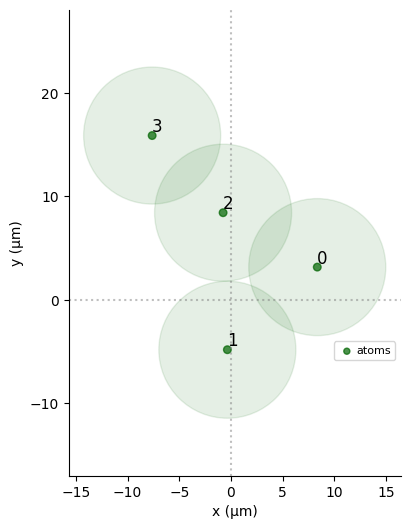

In [26]:
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

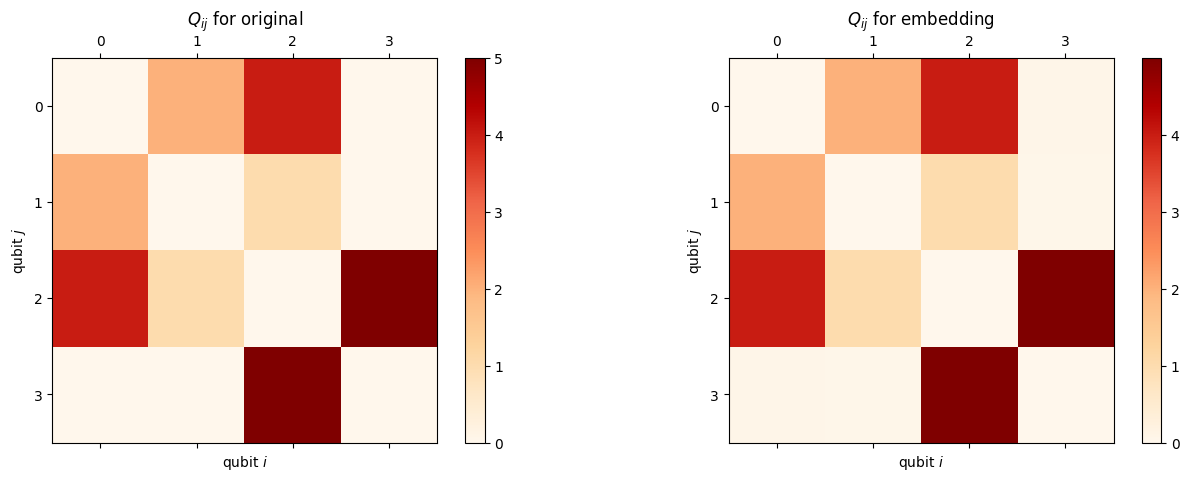

In [27]:
Q_new = squareform(Chadoq2.interaction_coeff / pdist(coords) ** 6)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
cmap = plt.get_cmap('OrRd')
# norm = mpl.colors.Normalize(vmin=0, vmax=1)

plot_Q = [Q_init, Q_new]
titles = ['original', 'embedding']
k = 0
for ax in axes.flat:

    # Q_plot = plot_Q[k]/np.max(plot_Q[k])
    Q_plot = plot_Q[k]
    norm = mpl.colors.Normalize(vmin=np.min(Q_plot), vmax=np.max(Q_plot))

    img = ax.matshow(Q_plot, cmap=cmap)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    ax.set_xticks(np.arange(len(Q_init)))
    ax.set_yticks(np.arange(len(Q_init)))
    ax.set_xlabel(r'qubit $i$')
    ax.set_ylabel(r'qubit $j$')
    ax.set_title(r'$Q_{ij}$ for ' + titles[k])
    k += 1

plt.show()

In [28]:
R_min = np.min(pdist(coords))
print('R_min = ', R_min)
omega_max_theo = Chadoq2.interaction_coeff/R_min**6
print('Omega_max = ', omega_max_theo)

R_min =  10.135639603299227
Omega_max =  4.999252015720513


## 2. Building the quantum algorithm 

Now that the QUBO $Q$ is encoded in the Register, we can peprare the following Ising Hamiltonian $H_Q$:

$$ H_Q= \sum_{i=1}^N \frac{\hbar\Omega}{2} \sigma_i^x - \sum_{i=1}^N \frac{\hbar \delta}{2} \sigma_i^z+\sum_{j \lt i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j. $$

In the case where our mapping of the atoms is perfect, the last sum replicates exactly the off-diagonal terms of $Q$. In that case, the next step is to prepare the ground-state of $H_Q$ to output the optimal bitstrings.

To do so we present two different approaches, namely the Quantum Approximation Optimization Algorithm (QAOA) and the Quantum Adiabatic Algorithm (QAA) that have been introduced to prepare ground-states of Hamiltonians.

### QAOA

This algorithm (see [Farhi, et al., 2014](https://arxiv.org/pdf/1411.4028.pdf)) has gained a lot of traction lately as a gate-based quantum algorithm. It has shown promising results in a number of applications and yields decent results for low-depth circuits.

All atoms are initially in the groundstate $|00\dots0\rangle$ of the `ground-rydberg` basis.  We then apply $p$ layers of alternating non-commutative Hamiltonians. The first one, called the mixing Hamiltonian $H_M$, is realized by taking $\Omega = 1$ rad/µs, and $\delta = 0$ rad/µs in the Hamiltonian equation. The second Hamiltonian $H_Q$ is realized with $\Omega =0$ rad/µs and $\delta = 1.$ rad/µs. $H_M$ and $H_Q$ are applied turn in turn with parameters $\tau$ and $t$ respectively. A classical optimizer is then used to estimate the optimal parameters. 

Instead of creating a new `Sequence` everytime the quantum loop is called, we are going to create a parametrized `Sequence` and give that to the quantum loop.

In [29]:
LAYERS = 2

# Parametrized sequence
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ch0", "rydberg_global")

t_list = seq.declare_variable("t_list", size=LAYERS)
s_list = seq.declare_variable("s_list", size=LAYERS)

for t, s in zip(t_list, s_list):
    pulse_1 = Pulse.ConstantPulse(1000 * t, 1.0, 0.0, 0)
    pulse_2 = Pulse.ConstantPulse(1000 * s, 0.0, 1.0, 0)

    seq.add(pulse_1, "ch0")
    seq.add(pulse_2, "ch0")

seq.measure("ground-rydberg")

Once we have the parameters that we want to apply, we use the `.build()` method to assign these values into a `assigned_seq` sequence. It is this sequence which is simulated every time the quantum loop is called.

Experimentally, we don't have access to the state vector $|\psi\rangle$. We therefore make it more realistic by taking samples from the state vector that results from running the simulation with `simul.run()`. This is done with the built-in method `results.sample_final_state()`, in which we add the measurement basis which was declared at the end of the sequence, and the number of samples desired. Currently, the repetition rate of the machine is $5$ Hz.

In [30]:
def quantum_loop(parameters):
    params = np.array(parameters)
    t_params, s_params = np.reshape(params.astype(int), (2, LAYERS))
    assigned_seq = seq.build(t_list=t_params, s_list=s_params)
    simul = Simulation(assigned_seq, sampling_rate=0.01)
    results = simul.run()
    count_dict = results.sample_final_state()  # sample from the state vector
    return count_dict

NOTE : There is no optimization here yet.

In [31]:
np.random.seed(123)  # ensures reproducibility of the tutorial
guess = {
    "t": np.random.uniform(8, 10, LAYERS),
    "s": np.random.uniform(1, 3, LAYERS),
}

In [32]:
example_dict = quantum_loop(np.r_[guess["t"], guess["s"]])

NameError: name 'Simulation' is not defined

We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

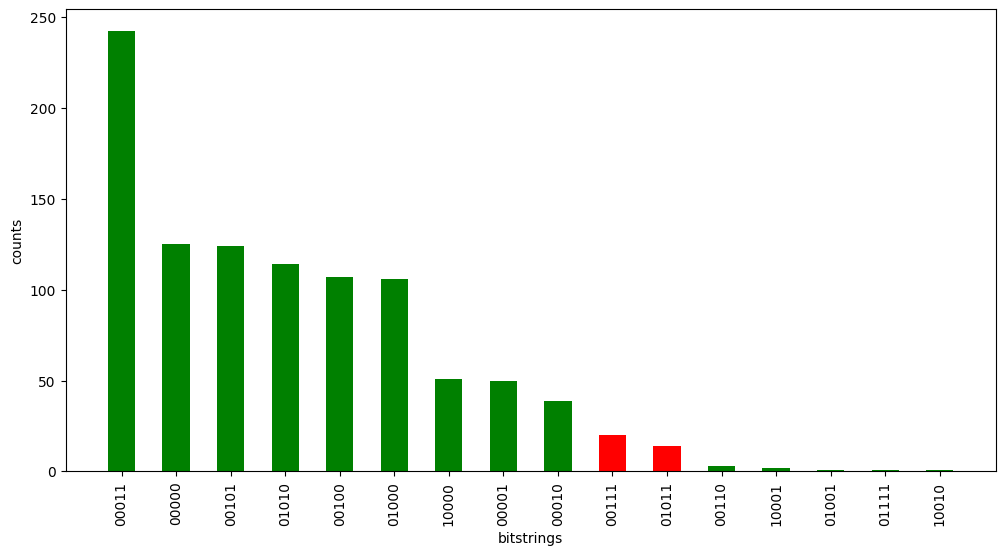

In [ ]:
plot_distribution(example_dict)

The bitstrings `01011` and `00111` (in red) correspond to the two optimal solutions (calculated at the beginning of the notebook). The goal of QAOA is to choregraph interferences between the basis states, in order to maximize the frequency of the optimal solution states. 

## 3. Optimization 

We estimate the cost of a sampled state vector by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating

$$
C({\bf z}) = {\bf z}^\top \cdot Q \cdot {\bf z}
$$

Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [ ]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

To perform a minimization loop, we define the following function that will be called at each step by SciPy. `*args` enables to pass the QUBO value, and `params` contains the trial value to score, which changes at each step.

In [ ]:
def func(param, *args):
    Q = args[0]
    C = quantum_loop(param)
    cost = get_cost(C, Q)
    return cost

### QAOA for depth $p = 2$

We now use a classical optimizer `minimize` in order to find the best variational parameters. This function takes as arguments `func`, the QUBO $Q$ and an initial point `x0` for the simplex in Nelder-Mead minimization. As the optimizer might get trapped in local minima, we repeat the optimization 20 times and select the parameters that yield the best approximation ratio.

In [ ]:
scores = []
params = []
for repetition in range(20):
    guess = {
        "t": np.random.uniform(1, 10, LAYERS),
        "s": np.random.uniform(1, 10, LAYERS),
    }

    try:
        res = minimize(
            func,
            args=Q,
            x0=np.r_[guess["t"], guess["s"]],
            method="Nelder-Mead",
            tol=1e-5,
            options={"maxiter": 10},
        )
        scores.append(res.fun)
        params.append(res.x)
    except Exception as e:
        pass

We can now plot the sample that we would obtain using the optimal variational parameters.

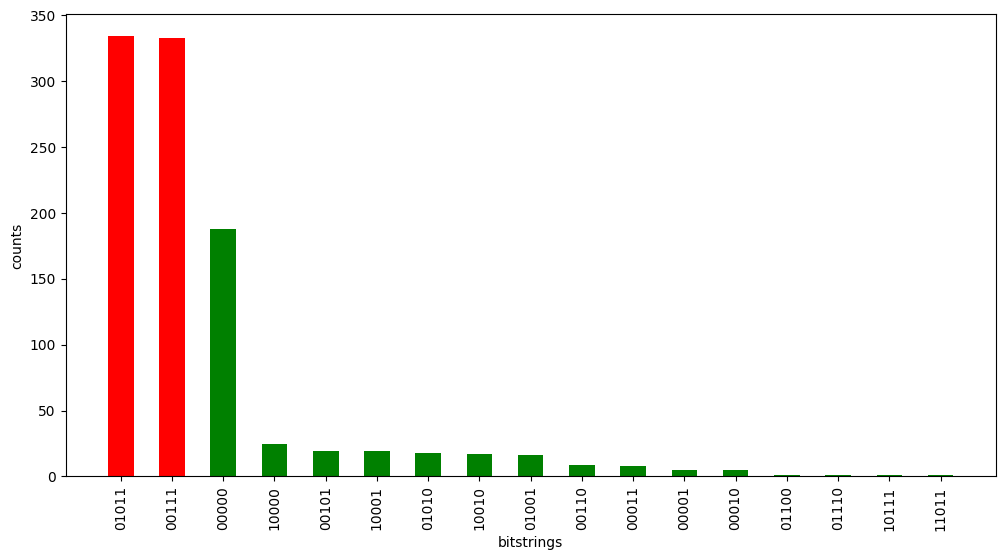

In [ ]:
optimal_count_dict = quantum_loop(params[np.argmin(scores)])
plot_distribution(optimal_count_dict)

QAOA is capable of finding good variational parameters $\tau$ and $t$. Now, sampling from this final state $|\psi(t_{f})\rangle$ will return both optimal strings with high probability.

However, using QAOA to solve the problem is not the best idea; it's difficult to yield a >90% quality solution without going to high depths of the QAOA, implying that the growing closed-loop optimization can rapidly become expensive, with no guarantee of convergence. We therefore propose another approach called the Quantum Adiabatic Algorithm (QAA). This fast, reliant and exclusively analog method shows optimal convergence to the solution.

## Quantum Adiabatic Algorithm

The idea behind the adiabatic algorithm (see [Albash, Lidar, 2018](https://arxiv.org/pdf/1611.04471.pdf)) is to slowly evolve the system from an easy-to-prepare groundstate to the groundstate of $H_Q$. If done slowly enough, the system of atoms stays in the instantaneous ground-state.

In our case, we continuously vary the parameters $\Omega(t), \delta(t)$ in time, starting with $\Omega(0)=0, \delta(0)<0$ and ending with $\Omega(0)=0, \delta>0$. The ground-state of $H(0)$ corresponds to the initial state $|00000\rangle$ and the ground-state of $H(t_f)$ corresponds to the ground-state of $H_Q$.

The Rydberg blockade radius is directly linked to the Rabi frequency $\Omega$ and is obtained using `Chadoq2.rydberg_blockade_radius()`. In this notebook, $\Omega$ is initially fixed to a frequency of 1 rad/µs. We can therefore build the adjacency matrix $A$ of $G$ in the following way:

To ensure that we are not exciting the system to states that are too excited, we keep $\Omega \in [0, \Omega_{\text{max}}]$, and choose $\Omega_{\text{max}}$ as the median of the values of Q to ensures that the adiabatic path is efficient.

In [33]:
# We choose a median value between the min and the max
# Omega = np.median(Q_new[Q_new > 0].flatten())
Omega = omega_max_theo
delta_0 = -10  # just has to be negative
delta_f = -np.mean(Q_diag)  # just has to be positive
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

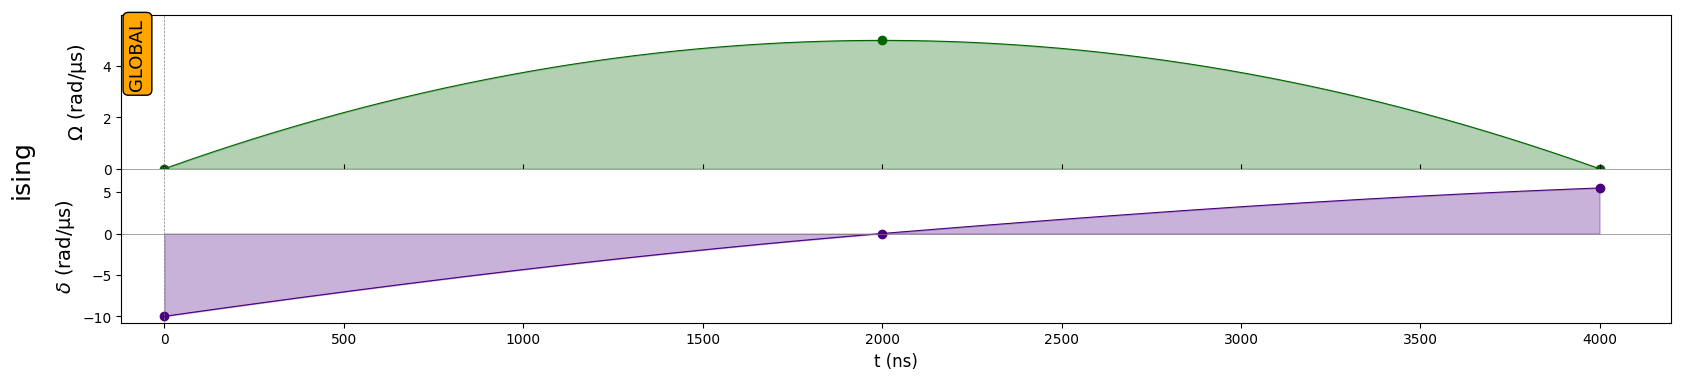

In [34]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)

#use DMM to apply the delta_0 
seq = Sequence(reg, Chadoq2)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [35]:
simul = QutipEmulator.from_sequence(seq)
N_samples = 2000
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples=N_samples)

In [47]:
count_dict.items()

dict_items([('0001', 2), ('0010', 4), ('0011', 3), ('0100', 3), ('0101', 157), ('0110', 55), ('0111', 81), ('1000', 2), ('1001', 106), ('1010', 3), ('1011', 6), ('1100', 18), ('1101', 1480), ('1110', 29), ('1111', 51)])

In [48]:
result_output = ['0011', '1011']

In [50]:
[int(result_output[0][i]) for i in range(4)]

[0, 0, 1, 1]

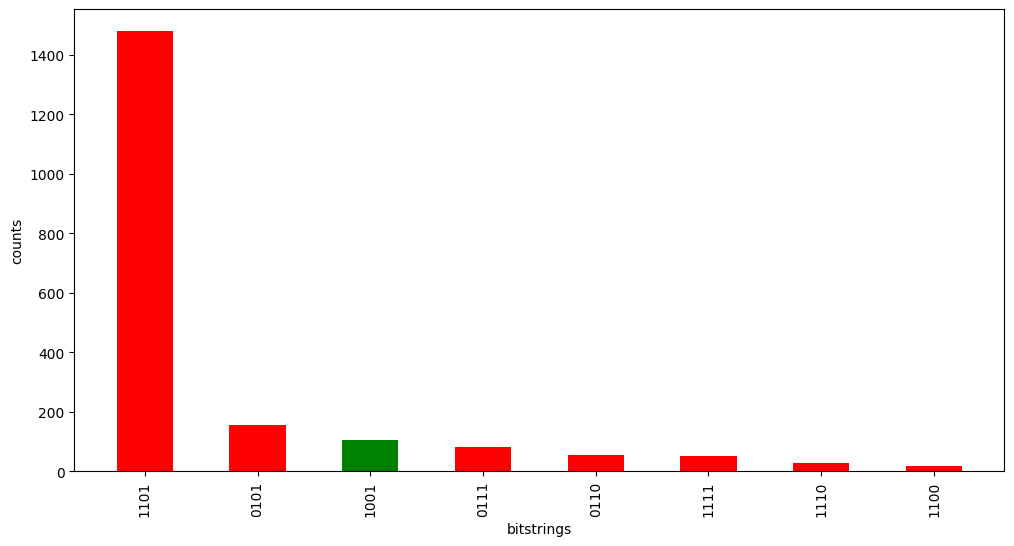

In [42]:
filter_count_dict = {}
for key in count_dict.keys():
    if count_dict[key] > 10:
        filter_count_dict.update({key:count_dict[key]})


plot_distribution_sol(filter_count_dict, degenerate_minima)

In [43]:
filter_count_dict

{'0101': 157,
 '0110': 55,
 '0111': 81,
 '1001': 106,
 '1100': 18,
 '1101': 1480,
 '1110': 29,
 '1111': 51}

In [82]:
print('string  |  count  |  cost')
for bstring, count in filter_count_dict.items():
    # print(bstring)
    # test_string = '1001'
    z = np.array(list(bstring), dtype=int)
    Q_hardware = np.copy(Q_new)
    np.fill_diagonal(Q_hardware, -delta_f)
    cost = z.T @ Q_hardware @ z
    print(bstring, count, cost)

string  |  count  |  cost
0101 142 -10.903132787708483
0110 51 -9.003444863700626
0111 91 -4.408073619968082
1001 97 -10.850401264015389
1100 21 -6.999497179512411
1101 1523 -12.253031231236282
1110 16 -2.5044348790767463
1111 44 2.2405351006404093


Now, implement the **real** QUBO using the DMM

In [84]:
np.multiply(Q_diag, -1)

array([5, 3, 8, 6])

In [103]:
Omega = omega_max_theo
delta_0 = -10  # just has to be negative
delta_f = np.max(np.multiply(Q_diag, -1))  # just has to be positive
print('delta_0', delta_0)
print('delta_f global', delta_f)
T = 4000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

delta_0 -10
delta_f global 8


In [109]:
final_delta_f_per_site = -(delta_f - np.multiply(Q_diag, -1))
print(final_delta_f_per_site)
amplitude_dmm_channel = np.sum(final_delta_f_per_site)
print('total detuning amplitude for DMM', amplitude_dmm_channel)
weights = np.abs(final_delta_f_per_site / amplitude_dmm_channel)
print('weights', weights)

[-3 -5  0 -2]
total detuning amplitude for DMM -10
weights [0.3 0.5 0.  0.2]


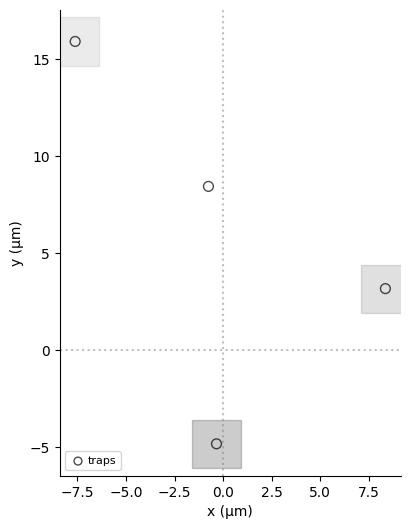

In [110]:
register = Register.from_coordinates(
    coords, center=False, prefix="q"
)
det_map_from_reg = register.define_detuning_map(
    {
        f"q{i}": weights[i] for i in range(len(Q_diag))
    }  # mapping between qubit ids and weights
)

det_map_from_reg.draw()


In [113]:
from dataclasses import replace
from pulser.channels.dmm import DMM
from pulser.devices import AnalogDevice
from pulser.register.weight_maps import DetuningMap
from pulser.waveforms import ConstantWaveform, RampWaveform

In [112]:
dmm = DMM(
    clock_period=4,
    min_duration=16,
    max_duration=2**26,
    mod_bandwidth=8,
    bottom_detuning=-20,  # detuning between 0 and -20 rad/µs
)


mock_device = replace(
    AnalogDevice.to_virtual(),
    dmm_objects=(dmm, DMM()),
    reusable_channels=True,
)
print(mock_device.dmm_channels)

seq = Sequence(register, mock_device)
seq.config_detuning_map(det_map_from_reg, "dmm_0")
print(seq.declared_channels)

{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg'), 'dmm_1': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 1 ns, Minimum pulse duration: 1 ns, Maximum pulse duration: 100000000 ns, Basis: 'ground-rydberg')}
{'dmm_0': DMM.Global(Max Absolute Detuning: None, Max Amplitude: 0, Clock period: 4 ns, Minimum pulse duration: 16 ns, Maximum pulse duration: 67108864 ns, Modulation Bandwidth: 8 MHz, Basis: 'ground-rydberg')}


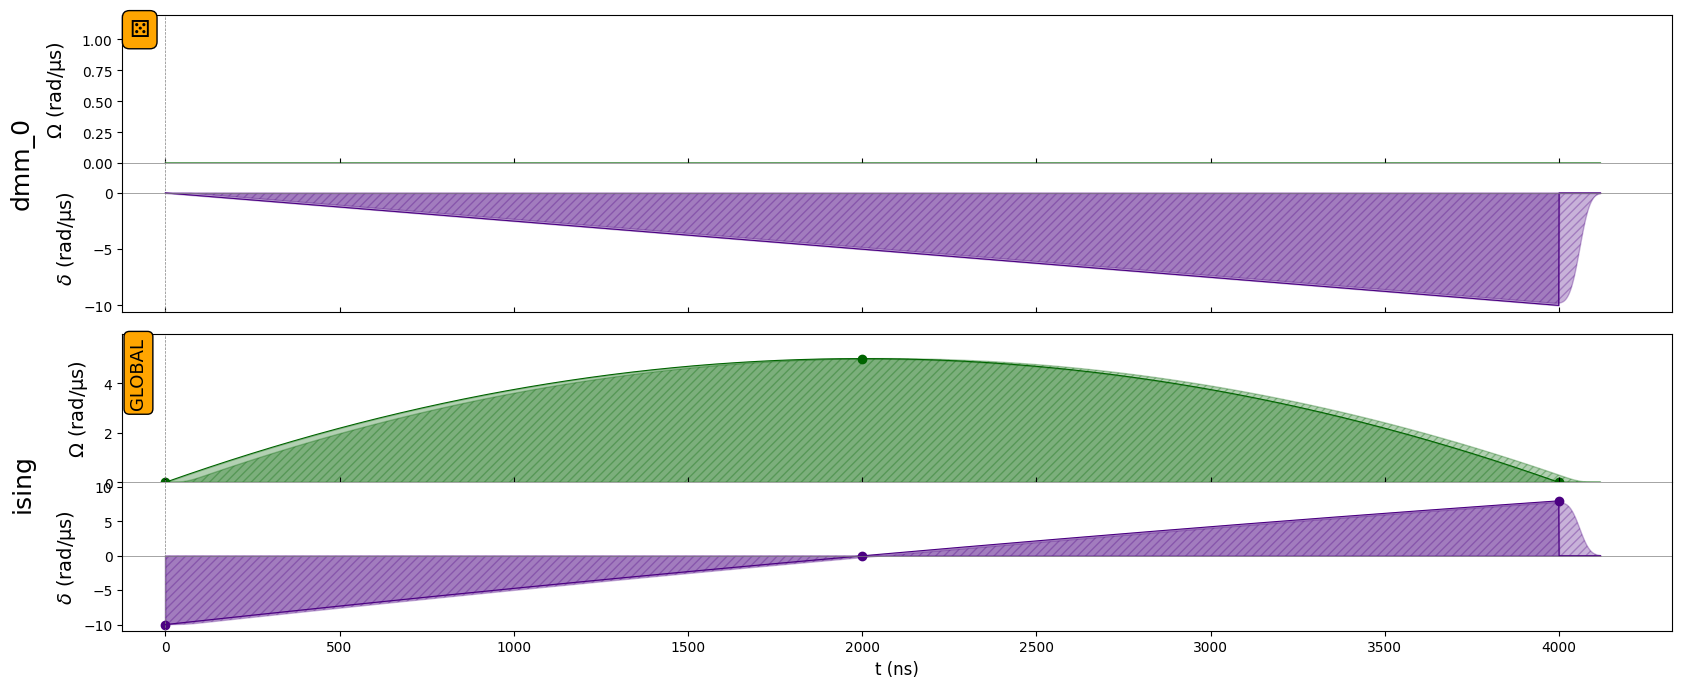

In [114]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)



#use DMM to apply the delta_0 
seq = Sequence(register, mock_device)
seq.config_detuning_map(det_map_from_reg, "dmm_0")
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.add_dmm_detuning(RampWaveform(T, 0, amplitude_dmm_channel), "dmm_0")  # added at t=100
seq.draw()

In [115]:
simul = QutipEmulator.from_sequence(seq)
N_samples = 2000
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state(N_samples=N_samples)

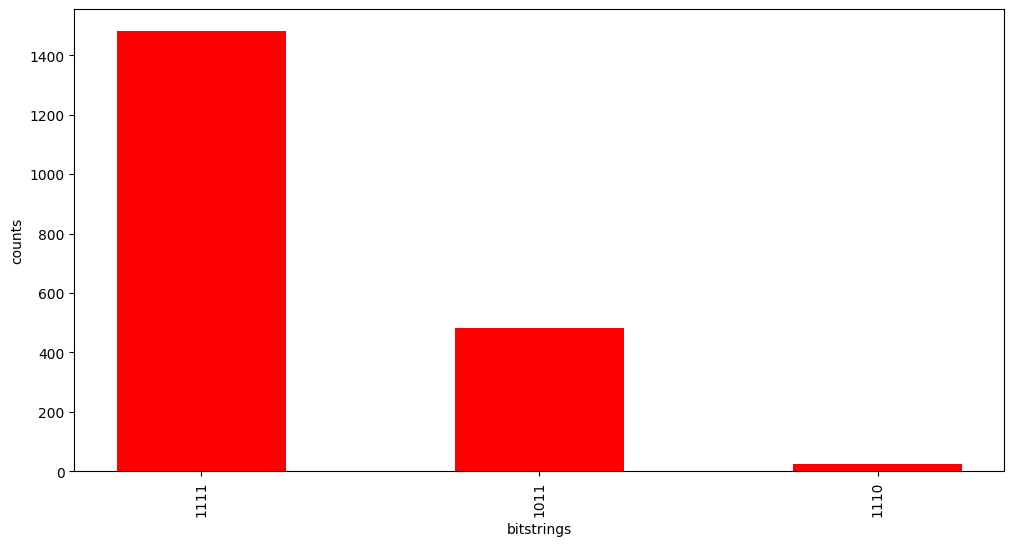

In [116]:
filter_count_dict = {}
for key in count_dict.keys():
    if count_dict[key] > 10:
        filter_count_dict.update({key:count_dict[key]})


plot_distribution_sol(filter_count_dict, degenerate_minima)

### How does the time evolution affect the quality of the results?

In [29]:
cost = []
for T in 1000 * np.linspace(1, 10, 10):
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    # simul = Simulation(seq)
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost.append(get_cost(count_dict, Q) / 3)

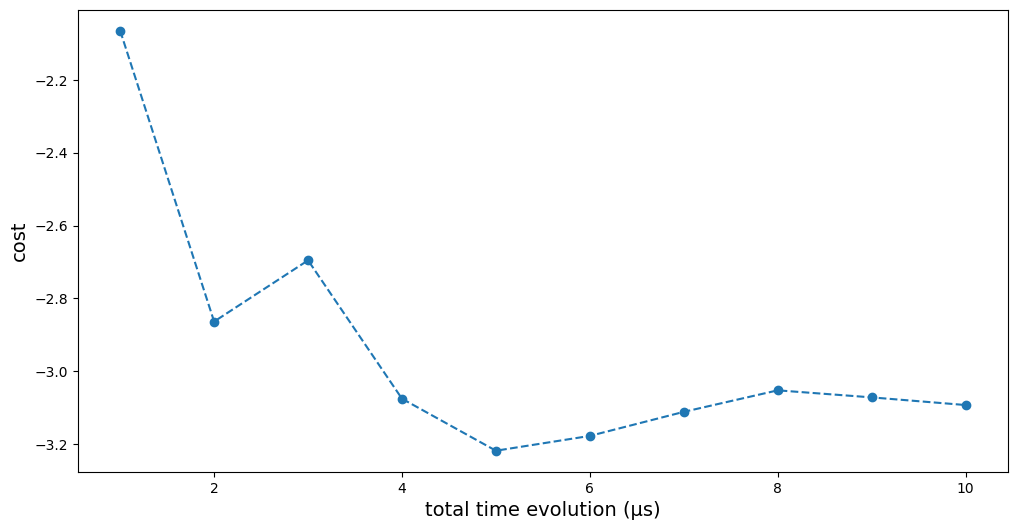

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), np.array(cost), "--o")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.show()

Not that, above, the answer is $-9$, whereas in the first cell, the answer is $-22$. This is because the onsite terms $U_{ii}$ are not taken into account! Not sure about that frankly...